# Spatial CV

In this example ([original version](https://github.com/WalidGharianiEAGLE/spatial-kfold/blob/main/notebooks/spatialkfold_intro.ipynb)) we perform spatial resampling using

1. k-means clustering
2. spatial blocking

and then spatial cross-validation on a simple linear regression model.


The dataset is adapted from the well-known [Ames housing study](https://www.kaggle.com/datasets/shashanknecrothapa/ames-housing-dataset) with the important inclusion of un underlying, geolocated world map. The data file that is loaded here is a `geojson` type (see [site](https://geojson.org/)), commonly used in GIS systems. This results in an additional column, `geometry`, containing the long-lat coordinates of the geographical item - the house.

## Requirements

This example uses the [spatialkfold](https://github.com/WalidGharianiEAGLE/spatial-kfold) package that must be installed before.

In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold 
from sklearn.model_selection import LeaveOneGroupOut 
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from spatialkfold.blocks import spatial_blocks 
from spatialkfold.datasets import load_ames
from spatialkfold.clusters import spatial_kfold_clusters 
from spatialkfold.plotting import spatial_kfold_plot
from spatialkfold.stats import spatial_kfold_stats

In [22]:
# Load the geojson file
data = gpd.read_file('./ames.geojson')
print(type(data))
data.head()

<class 'geopandas.geodataframe.GeoDataFrame'>


,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,...,Pool_QC,Fence,Misc_Feature,Misc_Val,Mo_Sold,Year_Sold,Sale_Type,Sale_Condition,Sale_Price,geometry
0,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141.0,31770,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,No_Pool,No_Fence,None,0,5,2010,WD,Normal,215000,POINT (-93.61975 42.05404)
1,One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80.0,11622,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,No_Pool,Minimum_Privacy,None,0,6,2010,WD,Normal,105000,POINT (-93.61976 42.05301)
2,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81.0,14267,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,No_Pool,No_Fence,Gar2,12500,6,2010,WD,Normal,172000,POINT (-93.61939 42.05266)
3,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,93.0,11160,Pave,No_Alley_Access,Regular,Lvl,AllPub,Corner,...,No_Pool,No_Fence,None,0,4,2010,WD,Normal,244000,POINT (-93.61732 42.05124)
4,Two_Story_1946_and_Newer,Residential_Low_Density,74.0,13830,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,...,No_Pool,Minimum_Privacy,None,0,3,2010,WD,Normal,189900,POINT (-93.63893 42.0609)


## Displaying the Ames Data

For display purposes, we will superpose the Ames geographical data onto a world map, using the `contextily` package. This package retrieves tile maps from the internet (OpenStreetMap here) and can then add those tiles as basemaps to matplotlib figures.

First, we have to ensure that the coordinate reference systems (CRS) of the tiles and the data match. Web map tiles are typically provided in Web Mercator (EPSG 3857).

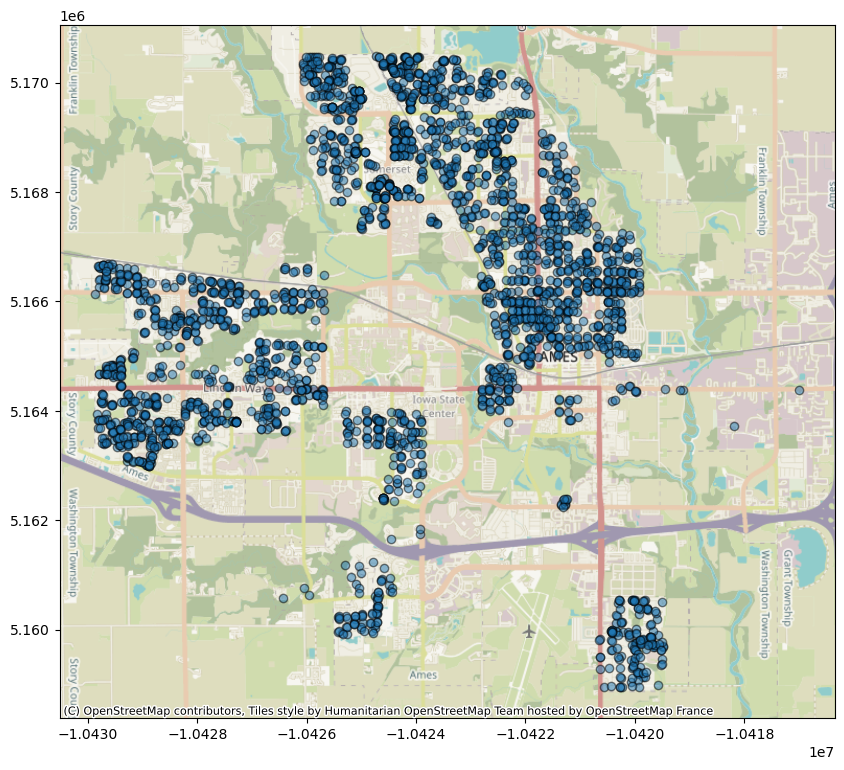

In [26]:
# display without map
#data.plot()
# display with tile map
import contextily as cx
data_wm = data.to_crs(epsg=3857)
ax = data_wm.plot(figsize=(10, 10), alpha=0.5, edgecolor="k")
cx.add_basemap(ax)

# I. Spatial Resampling

In [2]:
ames = load_ames()

In [3]:
ames.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [4]:
ames.head()

,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,...,Pool_QC,Fence,Misc_Feature,Misc_Val,Mo_Sold,Year_Sold,Sale_Type,Sale_Condition,Sale_Price,geometry
0,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141.0,31770,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,No_Pool,No_Fence,None,0,5,2010,WD,Normal,215000,POINT (-93.61975 42.05404)
1,One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80.0,11622,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,No_Pool,Minimum_Privacy,None,0,6,2010,WD,Normal,105000,POINT (-93.61976 42.05301)
2,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81.0,14267,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,No_Pool,No_Fence,Gar2,12500,6,2010,WD,Normal,172000,POINT (-93.61939 42.05266)
3,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,93.0,11160,Pave,No_Alley_Access,Regular,Lvl,AllPub,Corner,...,No_Pool,No_Fence,None,0,4,2010,WD,Normal,244000,POINT (-93.61732 42.05124)
4,Two_Story_1946_and_Newer,Residential_Low_Density,74.0,13830,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,...,No_Pool,Minimum_Privacy,None,0,3,2010,WD,Normal,189900,POINT (-93.63893 42.0609)


<Axes: >

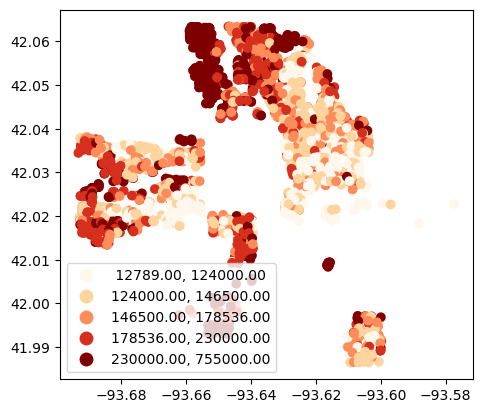

In [16]:
ames.plot(column='Sale_Price', cmap='OrRd', scheme='quantiles',legend=True) #, legend_kwds={"label": "Sale Price", "orientation": "horizontal"})

In [5]:
# Reproject to the approriate coordinate reference system 
ames_prj = ames.copy().to_crs(ames.estimate_utm_crs())

In [6]:
ames_prj.crs

<Projected CRS: EPSG:32615>
Name: WGS 84 / UTM zone 15N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 96°W and 90°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - Manitoba; Nunavut; Ontario. Ecuador -Galapagos. Guatemala. Mexico. United States (USA).
- bounds: (-96.0, 0.0, -90.0, 84.0)
Coordinate Operation:
- name: UTM zone 15N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [7]:
# Add an id column for each data point 
ames_prj['id'] = range(len(ames_prj))

<Axes: >

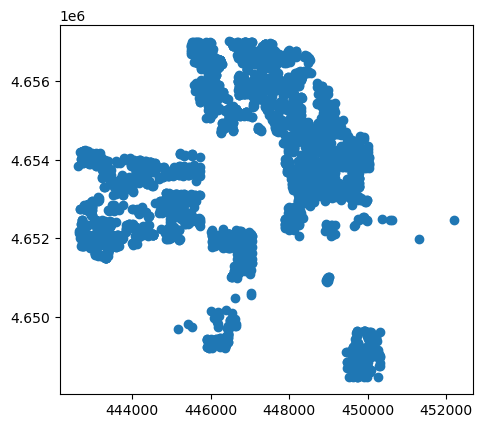

In [8]:
# Display the map
ames_prj.plot()

### 1. Spatial cluster resampling 

Two clustering algorithms are presented:

- [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) (By default)
- [BisectingKMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.BisectingKMeans.html)

#### 1.1 Using KMeans 

In [27]:
ames_clusters = spatial_kfold_clusters(gdf=ames_prj, name='id', nfolds= 10, algorithm='kmeans', random_state =569) 

In [28]:
ames_clusters

,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,...,Misc_Feature,Misc_Val,Mo_Sold,Year_Sold,Sale_Type,Sale_Condition,Sale_Price,geometry,id,folds
0,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141.0,31770,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,None,0,5,2010,WD,Normal,215000,POINT (448716.789 4655961.485),0,10
1,One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80.0,11622,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,None,0,6,2010,WD,Normal,105000,POINT (448715.802 4655848.124),1,10
2,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81.0,14267,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,Gar2,12500,6,2010,WD,Normal,172000,POINT (448746.026 4655808.487),2,10
3,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,93.0,11160,Pave,No_Alley_Access,Regular,Lvl,AllPub,Corner,...,None,0,4,2010,WD,Normal,244000,POINT (448915.962 4655650.253),3,10
4,Two_Story_1946_and_Newer,Residential_Low_Density,74.0,13830,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,...,None,0,3,2010,WD,Normal,189900,POINT (447135.458 4656735.276),4,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,Split_or_Multilevel,Residential_Low_Density,37.0,7937,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,CulDSac,...,None,0,3,2006,WD,Normal,142500,POINT (449905.137 4648727.785),2925,3
2926,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,0.0,8885,Pave,No_Alley_Access,Slightly_Irregular,Low,AllPub,Inside,...,None,0,6,2006,WD,Normal,131000,POINT (450078.246 4648654.392),2926,3
2927,Split_Foyer,Residential_Low_Density,62.0,10441,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,Shed,700,7,2006,WD,Normal,132000,POINT (449731.661 4648456.532),2927,3
2928,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,77.0,10010,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,None,0,4,2006,WD,Normal,170000,POINT (450286.53 4648942.397),2928,3


Note the addition of the columns:

- id
- fold

that contain the results of the clustering.

In [29]:
# Get the 'tab20' colormap
cols_tab = cm.get_cmap('tab20', 10)
# Generate a list of colors from the colormap
cols = [cols_tab(i) for i in range(10)]
# create a color ramp
color_ramp = ListedColormap(cols)

/var/folders/kx/_1g1vzv51nq1yv81c377flsr0000gn/T/ipykernel_29891/3378962096.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cols_tab = cm.get_cmap('tab20', 10)


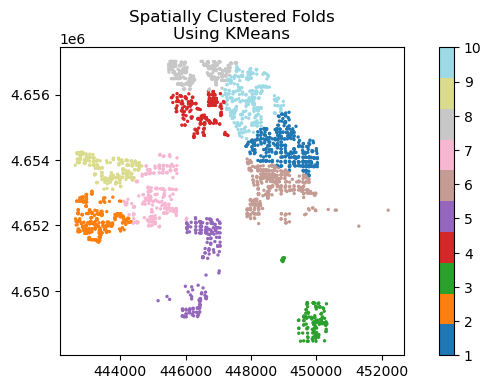

In [30]:
fig, ax = plt.subplots(1,1 , figsize=(9, 4)) 
ames_clusters.plot(column='folds', ax=ax, cmap=color_ramp, markersize=2, legend=True)
ax.set_title('Spatially Clustered Folds\nUsing KMeans')
plt.show()

In [31]:
# check the number of samples in train and test of the dependent variable for each fold
ames_clusters_stats = spatial_kfold_stats(X=ames_clusters, y=ames_clusters.Sale_Price, groups=ames_clusters.folds)

In [32]:
ames_clusters_stats

,split,train,test
0,1,2530,400
1,2,2606,324
2,3,2769,161
3,4,2651,279
4,5,2719,211
5,6,2531,399
6,7,2685,245
7,8,2583,347
8,9,2694,236
9,10,2602,328


#### 1.2 Using BisectingKMeans 

In [33]:
ames_clusters_Biskmeans = spatial_kfold_clusters(gdf=ames_prj, name='id', nfolds=10, algorithm='bisectingkmeans',random_state =569) 

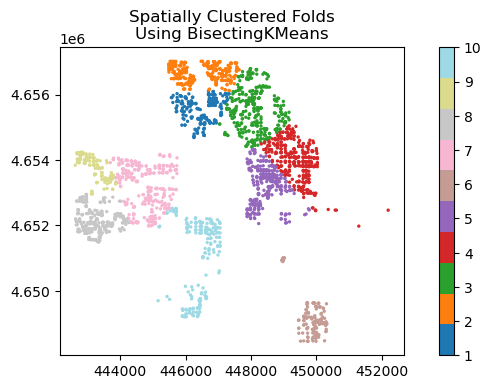

In [34]:
fig, ax = plt.subplots(1,1 , figsize=(9, 4)) 
ames_clusters_Biskmeans.plot(column='folds', ax=ax, cmap=color_ramp, markersize=2, legend=True)
ax.set_title('Spatially Clustered Folds\nUsing BisectingKMeans')
plt.show()

In [35]:
ames_clusters_stats_ = spatial_kfold_stats(X=ames_clusters_Biskmeans, y=ames_clusters_Biskmeans.Sale_Price, groups=ames_clusters_Biskmeans.folds)

In [36]:
ames_clusters_stats_

,split,train,test
0,1,2648,282
1,2,2553,377
2,3,2545,385
3,4,2556,374
4,5,2595,335
5,6,2769,161
6,7,2598,332
7,8,2616,314
8,9,2794,136
9,10,2696,234


### 2. Spatial Blocks

#### 2.1 Spatial resampled random blocks

In [37]:
# create 10 random blocks 
ames_rnd_blocks = spatial_blocks(gdf=ames_prj, width=1500, height=1500, 
                                 method='random', nfolds=10, 
                                 random_state=135)

/opt/miniconda3/envs/geo_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'GeoDataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'GeoDataFrame.transpose' instead.
  return bound(*args, **kwds)
/opt/miniconda3/envs/geo_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'GeoDataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'GeoDataFrame.transpose' instead.
  return bound(*args, **kwds)
/opt/miniconda3/envs/geo_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'GeoDataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'GeoDataFrame.transpose' instead.
  return bound(*args, **kwds)
/opt/miniconda3/envs/geo_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'GeoDataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'GeoDataFrame.transpose' instead

Text(0.5, 1.0, 'Random Blocks Folds')

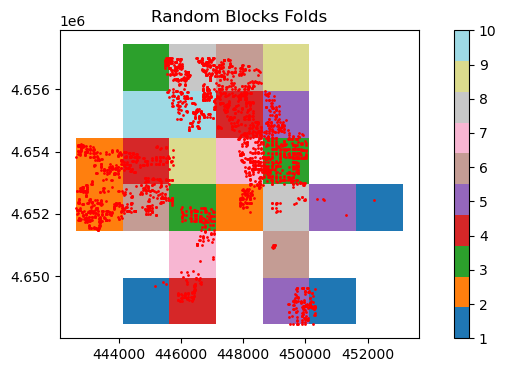

In [38]:
fig, ax = plt.subplots(1,1 , figsize=(9, 4)) 

ames_rnd_blocks.plot(column='folds', cmap=color_ramp, ax=ax ,lw=0.7, legend=True)
ames_prj.plot(ax=ax, markersize=1, color='r')
ax.set_title('Random Blocks Folds')

In [39]:
# resample the ames data with the prepared blocks 
ames_res_rnd_blk = gpd.overlay(ames_prj, ames_rnd_blocks)

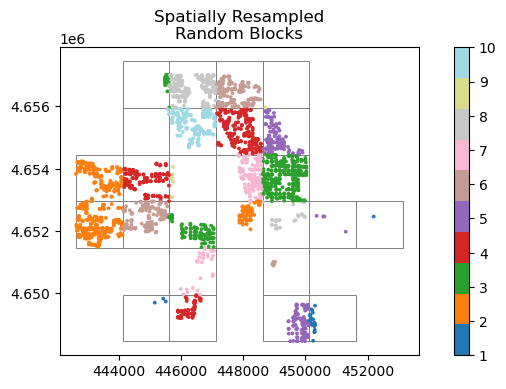

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(9, 4)) 

ames_rnd_blocks.plot(facecolor="none", edgecolor='grey', ax=ax, lw=0.7)
ames_res_rnd_blk.plot(column='folds', cmap=color_ramp, legend=True, ax=ax, markersize=3)
ax.set_title('Spatially Resampled\nRandom Blocks')
plt.show()

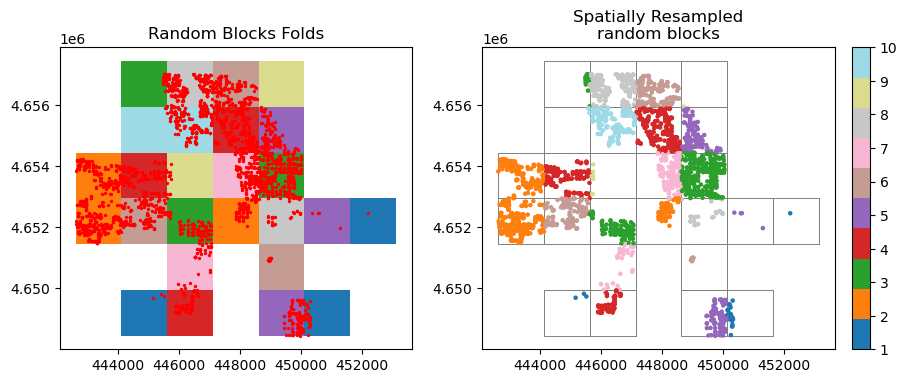

In [41]:
fig, ax = plt.subplots(1,2 , figsize=(10, 6)) 

# plot 1
ames_rnd_blocks.plot(column='folds', cmap=color_ramp, ax=ax[0] , lw=0.7, legend=False)
ames_prj.plot(ax=ax[0], markersize=2, color='r')
ax[0].set_title('Random Blocks Folds')

# plot 2
ames_rnd_blocks.plot(facecolor="none", edgecolor='grey', ax=ax[1], lw=0.7, legend=False)
ames_res_rnd_blk.plot(column='folds', cmap=color_ramp, legend=False, ax=ax[1], markersize = 2)
ax[1].set_title('Spatially Resampled\nrandom blocks')


im1 = ax[1].scatter(ames_res_rnd_blk.geometry.x , ames_res_rnd_blk.geometry.y, c=ames_res_rnd_blk['folds'],
                 cmap=color_ramp, s=5)

axins1 = inset_axes(
    ax[1],
    width="5%",  # width: 5% of parent_bbox width
    height="50%",  # height: 50%
    loc="lower left",
    bbox_to_anchor=(1.05, 0, 1, 2),
    bbox_transform=ax[1].transAxes,
    borderpad=0
)
fig.colorbar(im1, cax=axins1, ticks= range(1,11))


plt.show()

In [42]:
ames_res_rnd_blk_stats = spatial_kfold_stats(X=ames_res_rnd_blk, y=ames_res_rnd_blk.Sale_Price, groups=ames_res_rnd_blk.folds)

In [43]:
ames_res_rnd_blk_stats

,split,train,test
0,1,2893,37
1,2,2371,559
2,3,2414,516
3,4,2472,458
4,5,2687,243
5,6,2608,322
6,7,2720,210
7,8,2589,341
8,9,2920,10
9,10,2696,234


#### 2.2 Continuous spatial resampled blocks 

Two option are availble with orientation :
 - 'tb-lr' : top-bottom, left-right
 - ''bt-rl' : bottom-top, right-left

#####  2.2.1. 'tb-lr' : top-bottom, left-right

In [44]:
ames_cont_blocks = spatial_blocks(gdf=ames_prj, width=1500, height=1500, 
                                  method='continuous', orientation='tb-lr',
                                  nfolds=10, random_state=135)

/opt/miniconda3/envs/geo_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'GeoDataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'GeoDataFrame.transpose' instead.
  return bound(*args, **kwds)
/opt/miniconda3/envs/geo_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'GeoDataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'GeoDataFrame.transpose' instead.
  return bound(*args, **kwds)
/opt/miniconda3/envs/geo_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'GeoDataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'GeoDataFrame.transpose' instead.
  return bound(*args, **kwds)
/opt/miniconda3/envs/geo_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'GeoDataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'GeoDataFrame.transpose' instead

Text(0.5, 1.0, 'Continuous Blocks Folds\norientation:"tb-lr"')

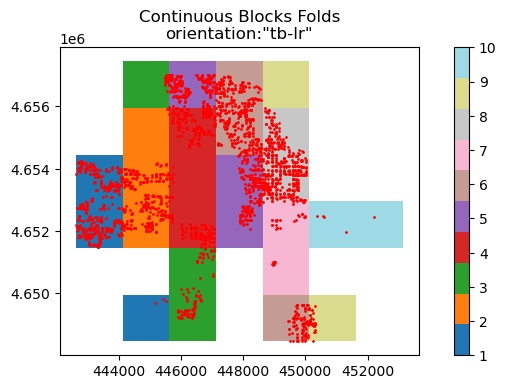

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(9, 4)) 

ames_cont_blocks.plot(column='folds', cmap=color_ramp, ax=ax , lw=0.7, legend=True)
ames_prj.plot(ax=ax, markersize=1, color='r')
ax.set_title('Continuous Blocks Folds\norientation:"tb-lr"')

In [46]:
# resample the ames data with the prepared blocks 
ames_res_cont_blk = gpd.overlay(ames_prj, ames_cont_blocks)

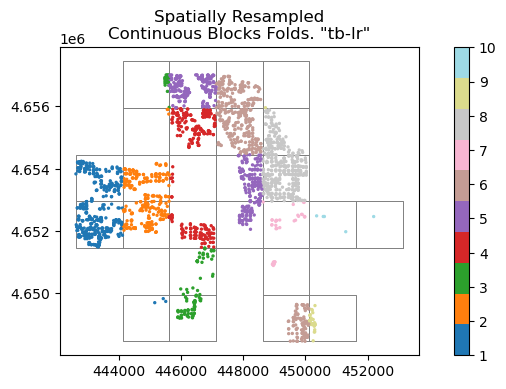

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(9, 4)) 

ames_cont_blocks.plot(facecolor="none", edgecolor='grey', ax=ax ,lw=0.7)
ames_res_cont_blk.plot(column='folds', cmap=color_ramp, legend=True, ax=ax, markersize=2)
ax.set_title('Spatially Resampled\nContinuous Blocks Folds. "tb-lr"')
plt.show()

In [48]:
ames_res_cont_blk_stats = spatial_kfold_stats(X=ames_res_cont_blk, y=ames_res_cont_blk.Sale_Price, groups=ames_res_cont_blk.folds)

In [49]:
ames_res_cont_blk_stats

,split,train,test
0,1,2446,484
1,2,2628,302
2,3,2801,129
3,4,2567,363
4,5,2367,563
5,6,2402,528
6,7,2894,36
7,8,2444,486
8,9,2896,34
9,10,2925,5


#####  2.2.2. 'bt-rl' : bottom-top, right-left

In [50]:
ames_cont_blocks_rev = spatial_blocks(gdf=ames_prj, width=1500, height=1500, 
                                      method='continuous', orientation='bt-rl',
                                      nfolds=10, random_state=135)

/opt/miniconda3/envs/geo_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'GeoDataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'GeoDataFrame.transpose' instead.
  return bound(*args, **kwds)
/opt/miniconda3/envs/geo_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'GeoDataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'GeoDataFrame.transpose' instead.
  return bound(*args, **kwds)
/opt/miniconda3/envs/geo_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'GeoDataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'GeoDataFrame.transpose' instead.
  return bound(*args, **kwds)
/opt/miniconda3/envs/geo_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'GeoDataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'GeoDataFrame.transpose' instead

Text(0.5, 1.0, 'Continuous Blocks Folds\norientation:"bt-rl"')

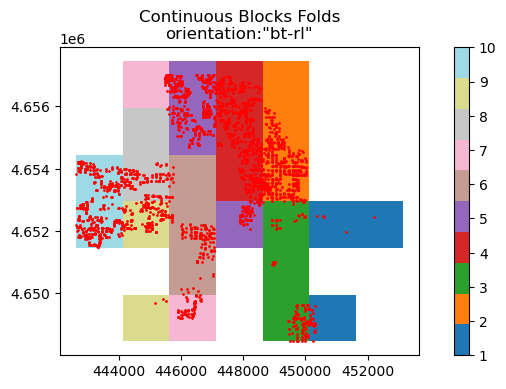

In [51]:
fig, ax = plt.subplots(1, 1 , figsize=(9, 4)) 

ames_cont_blocks_rev.plot(column='folds',cmap=color_ramp, ax=ax , lw=0.7, legend=True)
ames_prj.plot(ax=ax, markersize=1, color='r')
ax.set_title('Continuous Blocks Folds\norientation:"bt-rl"')

In [52]:
# resample the ames data with the prepared blocks 
ames_res_cont_blk_rev = gpd.overlay(ames_prj, ames_cont_blocks_rev)

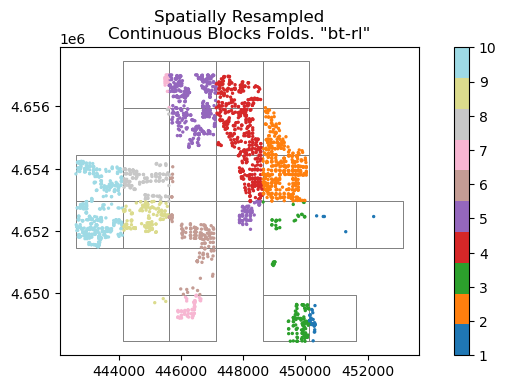

In [53]:
fig, ax = plt.subplots(1, 1 , figsize=(9, 4)) 

ames_cont_blocks_rev.plot(facecolor="none", edgecolor='grey', ax=ax, lw=0.7)
ames_res_cont_blk_rev.plot(column='folds', cmap=color_ramp, legend=True, ax=ax, markersize=2)
ax.set_title('Spatially Resampled\nContinuous Blocks Folds. "bt-rl"')
plt.show()

In [54]:
ames_res_cont_blk_rev_stats = spatial_kfold_stats(X=ames_res_cont_blk_rev, y=ames_res_cont_blk_rev.Sale_Price, groups=ames_res_cont_blk_rev.folds)

In [55]:
ames_res_cont_blk_rev_stats

,split,train,test
0,1,2892,38
1,2,2443,487
2,3,2776,154
3,4,2350,580
4,5,2306,624
5,6,2758,172
6,7,2841,89
7,8,2772,158
8,9,2783,147
9,10,2449,481


### 3. Plotting function 

Plot the partitioning of the data at each fold, as computed by the k-means clustering.

In [56]:
# check the folds number 
np.unique(ames_clusters.folds.values)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int32)

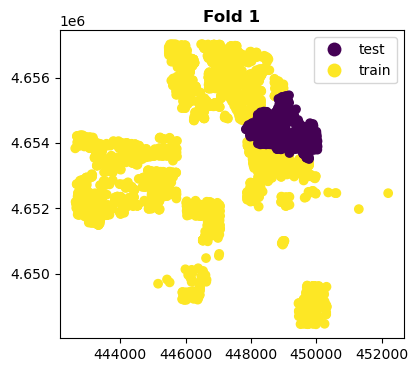

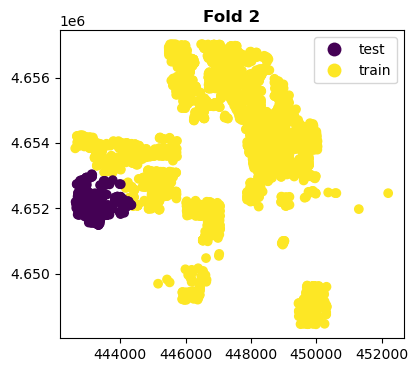

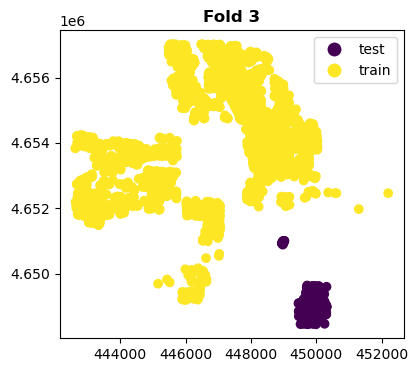

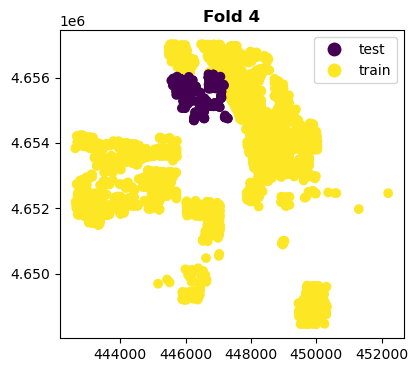

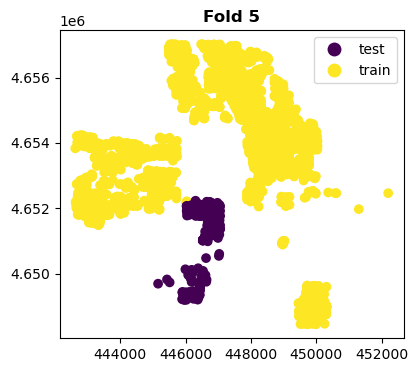

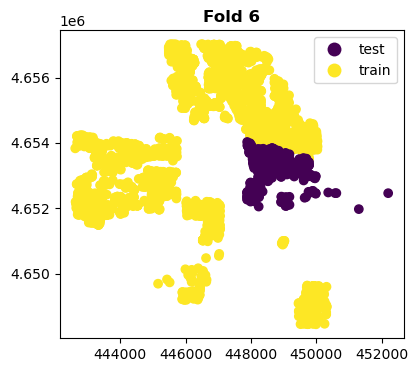

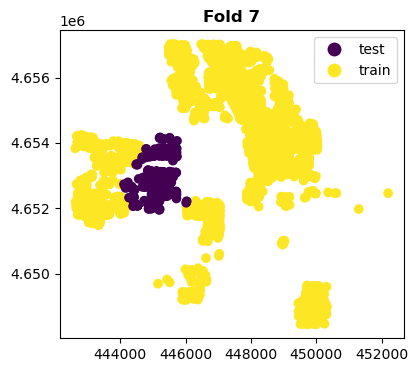

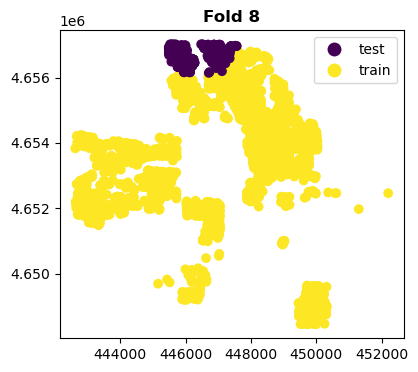

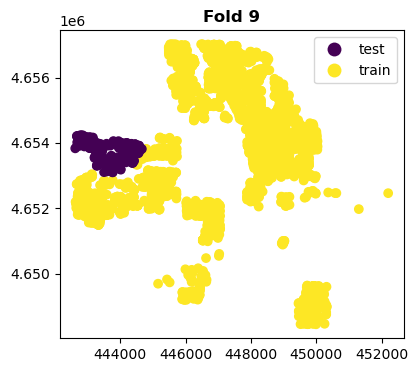

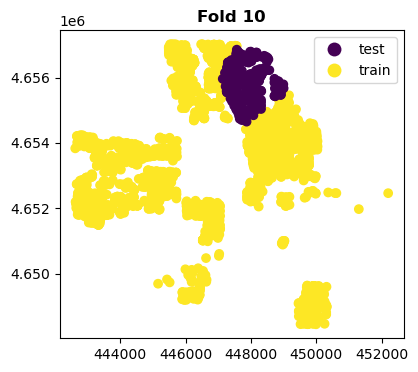

In [57]:
for i in range(1,11):
    fig, ax = plt.subplots(1, 1 ,figsize=(9, 4))

    spatial_kfold_plot(X=ames_clusters, 
                       geometry=ames_clusters.geometry, 
                       groups=ames_clusters.folds, 
                       fold_num=i, cmap='viridis', ax=ax)

## II. Comparison : Random vs. Spatial Cross validataion

Now, we can illustrate the effect of the spatial resmpling in the evaluation of the performance of a simple, linear regression machine learning model.

For this, we will compare

- random CV
- spatial CV by the k-means clustering.

In [58]:
x = ames_prj[['Year_Built', 'Bldg_Type', 'Gr_Liv_Area']]
y = ames_prj[['Sale_Price']]

le = preprocessing.LabelEncoder()
le.fit(x["Bldg_Type"])

list(le.classes_)

le.transform(ames_prj["Bldg_Type"])

array([1, 1, 1, ..., 1, 1, 1], shape=(2930,))

In [59]:
# Create a copy of the DataFrame and transform the 'Bldg_Type' column to float values
x_copy = x.copy()
x_copy['type'] = le.transform(x_copy["Bldg_Type"])

In [60]:
# Get the independent variables and the dependent variable
X = x_copy[['Year_Built', 'type', 'Gr_Liv_Area']]
y = ames_prj[['Sale_Price']]

In [61]:
X

,Year_Built,type,Gr_Liv_Area
0,1960,1,1656
1,1961,1,896
2,1958,1,1329
3,1968,1,2110
4,1997,1,1629
...,...,...,...
2925,1984,1,1003
2926,1983,1,902
2927,1992,1,970
2928,1974,1,1389


In [62]:
y

,Sale_Price
0,215000
1,105000
2,172000
3,244000
4,189900
...,...
2925,142500
2926,131000
2927,132000
2928,170000


#### 1. Random CV

We perform a (random) k-fold CV, with 10 folds.

In [63]:
# Initiate a linear regressor 
reg = LinearRegression()

# Initiate a random CV
kf = KFold(n_splits = 10, shuffle=True, random_state=123)

# evaluate the model and collect the results
random_n_scores = cross_validate(reg, X, y.values.ravel(), 
                                scoring= ['neg_root_mean_squared_error', 'r2', 'neg_mean_absolute_error'], 
                                cv=kf, n_jobs=-1, error_score='raise')

In [64]:
random_n_scores

{'fit_time': array([0.00127172, 0.00136089, 0.00135589, 0.00154805, 0.00219703,
        0.00128102, 0.00132799, 0.00247312, 0.002496  , 0.00212812]),
 'score_time': array([0.00090218, 0.00248194, 0.00097919, 0.00101209, 0.00104094,
        0.00092125, 0.00094199, 0.00249696, 0.00235391, 0.00211883]),
 'test_neg_root_mean_squared_error': array([-44622.40838673, -39772.65742074, -44832.52140754, -45450.03692245,
        -50212.56009308, -49287.98884697, -39787.31970143, -52631.12777371,
        -58187.6988452 , -38817.22221497]),
 'test_r2': array([0.68186786, 0.65778112, 0.71220595, 0.68753325, 0.62837042,
        0.6002097 , 0.69541257, 0.59591238, 0.61584596, 0.71330735]),
 'test_neg_mean_absolute_error': array([-30212.75246135, -28792.38398508, -31229.5572116 , -32461.80017946,
        -32897.03779732, -32580.57849056, -29550.97789663, -35188.52372995,
        -35547.25333851, -28150.39632891])}

In [65]:
rn_cv_r2 = np.mean(random_n_scores["test_r2"])
rn_cv_rmse = np.mean(abs(random_n_scores["test_neg_root_mean_squared_error"]))
rn_cv_mae = np.mean(abs(random_n_scores["test_neg_mean_absolute_error"]))

print('R2 :',rn_cv_r2)
print('RMSE :',rn_cv_rmse)
print('MAE :',rn_cv_mae)

R2 : 0.6588446547591043
RMSE : 46360.15416128094
MAE : 31661.12614193702


#### Spatial CV:

Use a Leave Region Out Cross validation, based on the k-means clustering performed before. 

In [66]:
# Initiate a leave group out cross valiadtion
group_cvs =  LeaveOneGroupOut()

# Evaluate the model and collect the results
spatial_cluster_scores = cross_validate(reg, X, y.values.ravel(), 
                                scoring= ['neg_root_mean_squared_error', 'r2', 'neg_mean_absolute_error'], 
                                cv= group_cvs.split(X, y, ames_clusters.folds.values.ravel()), # spatial cross validation
                                n_jobs=-1, error_score='raise')

In [67]:
spatial_cluster_scores

{'fit_time': array([0.00257325, 0.0023241 , 0.00275469, 0.00228   , 0.00221801,
        0.00243187, 0.00127006, 0.00115776, 0.00140977, 0.0012238 ]),
 'score_time': array([0.00197458, 0.00221705, 0.00278711, 0.00227499, 0.00226831,
        0.0012722 , 0.00113201, 0.0015521 , 0.0011282 , 0.00109529]),
 'test_neg_root_mean_squared_error': array([-29717.24670025, -53574.0001557 , -45746.18536977, -52105.40824432,
        -50221.40620804, -34591.69531388, -42368.97917593, -73949.00989437,
        -36288.31271365, -49592.56905517]),
 'test_r2': array([0.1867391 , 0.08606133, 0.42016374, 0.5940784 , 0.47318247,
        0.3319348 , 0.47949823, 0.39375644, 0.39517381, 0.65080079]),
 'test_neg_mean_absolute_error': array([-21763.69734391, -29348.50486361, -33609.13258888, -35706.81331469,
        -39445.77714301, -26474.24847997, -31662.88923717, -52032.25652523,
        -27085.76797277, -32110.48595883])}

In [68]:
sp_cv_r2 = np.mean(spatial_cluster_scores["test_r2"])
sp_cv_rmse = np.mean(abs(spatial_cluster_scores["test_neg_root_mean_squared_error"]))
sp_cv_mae = np.mean(abs(spatial_cluster_scores["test_neg_mean_absolute_error"]))

print('R2 :',sp_cv_r2)
print('RMSE :',sp_cv_rmse)
print('MAE :',sp_cv_mae)

R2 : 0.40113891169274957
RMSE : 46815.481283110006
MAE : 32923.957342808295


In [69]:
random_n_scores['test_r2']

array([0.68186786, 0.65778112, 0.71220595, 0.68753325, 0.62837042,
       0.6002097 , 0.69541257, 0.59591238, 0.61584596, 0.71330735])

In [70]:
df_rn_cv_scores = pd.DataFrame({'r2': random_n_scores['test_r2'], 
             'rmse' :abs(random_n_scores['test_neg_root_mean_squared_error']),
             'mae' : abs(random_n_scores["test_neg_mean_absolute_error"]),
            'cv_type' : 'Random CV'})

In [71]:
df_rn_cv_scores

,r2,rmse,mae,cv_type
0,0.681868,44622.408387,30212.752461,Random CV
1,0.657781,39772.657421,28792.383985,Random CV
2,0.712206,44832.521408,31229.557212,Random CV
3,0.687533,45450.036922,32461.800179,Random CV
4,0.628370,50212.560093,32897.037797,Random CV
5,0.600210,49287.988847,32580.578491,Random CV
6,0.695413,39787.319701,29550.977897,Random CV
7,0.595912,52631.127774,35188.523730,Random CV
8,0.615846,58187.698845,35547.253339,Random CV
9,0.713307,38817.222215,28150.396329,Random CV


In [72]:
df_sp_cv_scores = pd.DataFrame({'r2': spatial_cluster_scores['test_r2'], 
             'rmse' :abs(spatial_cluster_scores['test_neg_root_mean_squared_error']),
             'mae' : abs(spatial_cluster_scores["test_neg_mean_absolute_error"]),
            'cv_type' : 'Spatial CV'})

In [73]:
df_sp_cv_scores

,r2,rmse,mae,cv_type
0,0.186739,29717.246700,21763.697344,Spatial CV
1,0.086061,53574.000156,29348.504864,Spatial CV
2,0.420164,45746.185370,33609.132589,Spatial CV
3,0.594078,52105.408244,35706.813315,Spatial CV
4,0.473182,50221.406208,39445.777143,Spatial CV
5,0.331935,34591.695314,26474.248480,Spatial CV
6,0.479498,42368.979176,31662.889237,Spatial CV
7,0.393756,73949.009894,52032.256525,Spatial CV
8,0.395174,36288.312714,27085.767973,Spatial CV
9,0.650801,49592.569055,32110.485959,Spatial CV


In [74]:
cv_metrics = pd.concat([df_rn_cv_scores, df_sp_cv_scores])

In [75]:
cv_metrics

,r2,rmse,mae,cv_type
0,0.681868,44622.408387,30212.752461,Random CV
1,0.657781,39772.657421,28792.383985,Random CV
2,0.712206,44832.521408,31229.557212,Random CV
3,0.687533,45450.036922,32461.800179,Random CV
4,0.628370,50212.560093,32897.037797,Random CV
5,0.600210,49287.988847,32580.578491,Random CV
6,0.695413,39787.319701,29550.977897,Random CV
7,0.595912,52631.127774,35188.523730,Random CV
8,0.615846,58187.698845,35547.253339,Random CV
9,0.713307,38817.222215,28150.396329,Random CV


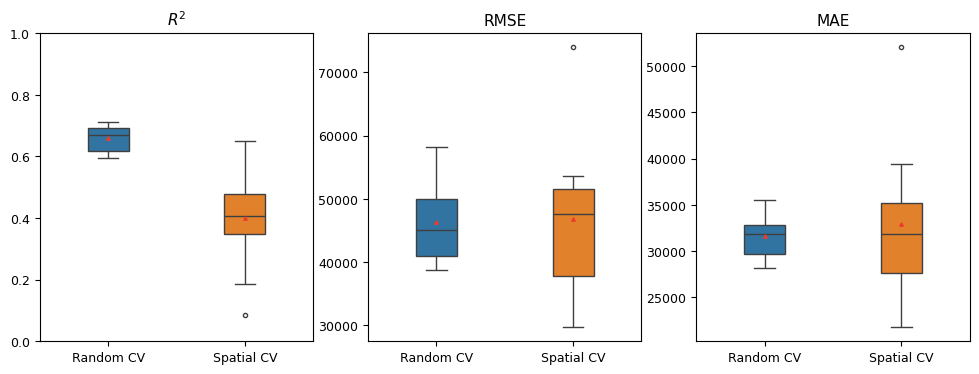

In [76]:
fig, ax =  plt.subplots(1, 3, figsize=(12, 4))

my_colors = {'Random CV': '#1f77b4', 'Spatial CV': '#ff7f0e', 'C': 'gold'}

sns.boxplot(data = cv_metrics,
            hue = 'cv_type', 
            x = 'cv_type',
            y = 'r2',  
            dodge=False, width = .3, linewidth = 1, ax = ax[0],
            #palette= 'coolwarm',
            palette = my_colors,
            showmeans=True, meanprops={"markersize": "2.5", "markerfacecolor" : "#ef3b2c",
                    "markeredgecolor" : "#ef3b2c"} ,flierprops=dict(markersize=3))

ax[0].set_title( r'$R^2$',fontsize=11)
ax[0].set_ylabel('')
ax[0].set_xlabel('')
ax[0].set_ylim(0, 1)
ax[0].tick_params(labelsize = 9)
ax[0].legend([],[], frameon=False)

#
sns.boxplot(data = cv_metrics,
            hue = 'cv_type', 
            x = 'cv_type',
            y = 'rmse',  
            dodge=False, width = .3, linewidth = 1, ax = ax[1],
            #palette= 'coolwarm',
            palette = my_colors,
           showmeans=True, meanprops={"markersize": "2.5",  "markerfacecolor" : "#ef3b2c",
                    "markeredgecolor" : "#ef3b2c"},  flierprops=dict(markersize=3))
ax[1].set_title('RMSE',fontsize=11)
ax[1].set_ylabel('')
ax[1].set_xlabel('')
ax[1].tick_params(labelsize = 9)
ax[1].legend([],[], frameon=False)

sns.boxplot(data = cv_metrics,
            hue = 'cv_type',
            x = 'cv_type',
            y = 'mae',  
            dodge=False, width = .3, linewidth = 1, ax = ax[2],
            #palette= 'coolwarm',
            palette = my_colors,
           showmeans=True, meanprops={"markersize": "2.5",  "markerfacecolor" : "#ef3b2c",
                    "markeredgecolor" : "#ef3b2c"},  flierprops=dict(markersize=3))
ax[2].set_title('MAE',fontsize=11)
ax[2].set_ylabel('')
ax[2].set_xlabel('')
ax[2].tick_params(labelsize = 9)

plt.legend([],[], frameon=False)
plt.show()

### Observations

The R2 is the most affected. The random CV provides an very optimistic value, compared to the spatial CV. This is less pronounced in the RMSE and MAE scores, which reveals that the prediction errors remain, on average, hte same, but have a much larger variability (the IQR is considerably bigger for the spatial CV).
